# Mini Project2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from surprise import SVD
from surprise import accuracy, Dataset, Reader

In [2]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [3]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

## Surprise - setup

In [4]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

# reader for range of ratings
reader = Reader(rating_scale=(1,5))

# convert train numpy array to data frame
train_df = pd.DataFrame(train, columns= ['User ID', 'Movie ID', 'Rating'])

# create surprise data object
train_ds = Dataset.load_from_df(train_df[['User ID','Movie ID', 'Rating']], reader)

# convert to train set
train_ts = train_ds.build_full_trainset()
train_ts.n_users = M # specify number of users
train_ts.n_items = N # specify number of items

Factorizing with  943  users,  1682  movies.


## Study regularization - no bias

Training model with M = 943, N = 1682, k = 20, eta = 0.001, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.005, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.01, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.1, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.001, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.005, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.01, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.1, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.001, reg = 0.001
Training model with M = 943, N = 1682, k = 20, eta = 0.005, reg = 0.001
Training model with M = 943, N = 1682, k = 20, eta = 0

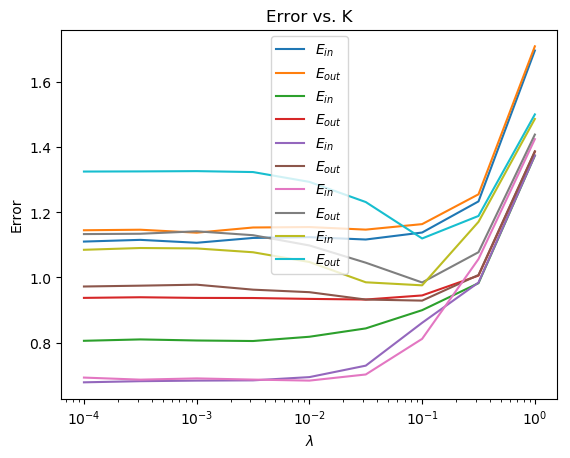

In [9]:
regs = np.logspace(-4,0,9)
etas = [0.001,0.005,0.01,0.05,0.1]
E_in = np.zeros((len(regs),len(etas)))
E_out = np.zeros((len(regs),len(etas)))

# Use to compute Ein and Eout
rdx = 0
for reg in regs:
    edx = 0
    for eta in etas:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
        algo = SVD(n_factors=K,biased=False,lr_all=eta,reg_all=reg)
        algo.fit(train_ts)
        predictions_train = algo.test(train)
        predictions_test = algo.test(test)
        E_in[rdx,edx] = accuracy.rmse(predictions_train,verbose=False)
        E_out[rdx,edx] = accuracy.rmse(predictions_test,verbose=False)
        edx += 1
    rdx += 1

## Visualize error

c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024EC709E5E0> has a label of '_' which cannot be automatically added to the legend.
  warnings.warn('The handle {!r} has a label of {!r} which '
c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024EC7533640> has a label of '_' which cannot be automatically added to the legend.
  warnings.warn('The handle {!r} has a label of {!r} which '
c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024EC5CA1940> has a label of '_' which cannot be automatically added to the legend.
  warnings.warn('The handle {!r} has a label of {!r} which '
c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.li

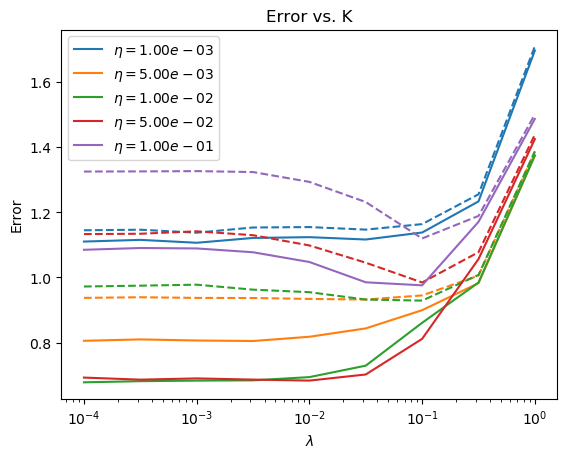

In [21]:
ax = plt.gca()
thisLeg = []
for edx in range(len(etas)):
    strEta = "$\eta = {:.2e}$".format(etas[edx])
    thisLeg.append(strEta)
    thisLeg.append("_")
    color = next(ax._get_lines.prop_cycler)['color']
    plt.semilogx(regs, E_in[:,edx],color = color)
    plt.semilogx(regs, E_out[:,edx], linestyle='dashed',color = color)
    plt.title('Error vs. K')
    plt.xlabel(r'$\lambda$')
    plt.ylabel('Error')
plt.legend(thisLeg)
plt.savefig('surprise.png')

## Study regularization - with bias

In [24]:
regs = np.logspace(-4,0,9)
etas = [0.001,0.005,0.01,0.05,0.1]
E_in = np.zeros((len(regs),len(etas)))
E_out = np.zeros((len(regs),len(etas)))

# Use to compute Ein and Eout
rdx = 0
for reg in regs:
    edx = 0
    for eta in etas:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
        algo = SVD(n_factors=K,biased=True,lr_all=eta,reg_all=reg)
        algo.fit(train_ts)
        predictions_train = algo.test(train)
        predictions_test = algo.test(test)
        E_in[rdx,edx] = accuracy.rmse(predictions_train,verbose=False)
        E_out[rdx,edx] = accuracy.rmse(predictions_test,verbose=False)
        edx += 1
    rdx += 1

Training model with M = 943, N = 1682, k = 20, eta = 0.001, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.005, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.01, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.1, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.001, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.005, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.01, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.05, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.1, reg = 0.00031622776601683794
Training model with M = 943, N = 1682, k = 20, eta = 0.001, reg = 0.001
Training model with M = 943, N = 1682, k = 20, eta = 0.005, reg = 0.001
Training model with M = 943, N = 1682, k = 20, eta = 0

## Visualize Error

c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024EC60D86D0> has a label of '_' which cannot be automatically added to the legend.
  warnings.warn('The handle {!r} has a label of {!r} which '
c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024EC60D8670> has a label of '_' which cannot be automatically added to the legend.
  warnings.warn('The handle {!r} has a label of {!r} which '
c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024EC5CAD310> has a label of '_' which cannot be automatically added to the legend.
  warnings.warn('The handle {!r} has a label of {!r} which '
c:\Users\micha\anaconda3\envs\surp_env\lib\site-packages\matplotlib\legend.py:590: UserWarning: The handle <matplotlib.li

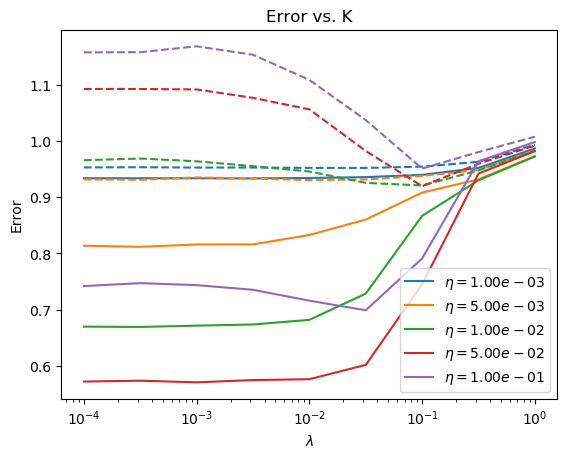

In [25]:
ax = plt.gca()
thisLeg = []
for edx in range(len(etas)):
    strEta = "$\eta = {:.2e}$".format(etas[edx])
    thisLeg.append(strEta)
    thisLeg.append("_")
    color = next(ax._get_lines.prop_cycler)['color']
    plt.semilogx(regs, E_in[:,edx],color = color)
    plt.semilogx(regs, E_out[:,edx], linestyle='dashed',color = color)
    plt.title('Error vs. K')
    plt.xlabel(r'$\lambda$')
    plt.ylabel('Error')
plt.legend(thisLeg)
plt.savefig('surpriseBias.png')

## Get final model

In [ ]:
algo = SVD(n_factors=K,biased=False,lr_all=eta,reg_all=1e-1)
algo.fit(train_ts)
predictions_train = algo.test(train)
predictions_test = algo.test(test)
accuracy.rmse(predictions_train)
accuracy.rmse(predictions_test)

# extract matrix
U = algo.pu
V = algo.qi
print("U is matrix of size ",U.shape[0]," by ",U.shape[1])
print("V is matrix of size ",V.shape[0]," by ",V.shape[1])

RMSE: 0.7888
RMSE: 0.9447
U is matrix of size  943  by  20
V is matrix of size  1682  by  20
